# Import libraries

In [ ]:
!pip install pandas_ta
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=4b9b2e20df4c8c0847f8ea7c47b7d0546dc7e697e3f33c59ee46ac0d99c2c0f4
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinu

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import pandas_ta as ta
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import random
from copy import deepcopy
from torch.optim import Adam
from torch.nn import MSELoss
import copy

## IBM

### Data Insights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IBM = pd.read_csv('/content/drive/MyDrive/ML_project/Data/IBM_weekly.csv')

In [ ]:
IBM.head()

,Date,Open,High,Low,Close,Volume
0,1994-03-06,53.125,53.875,52.125,8.0537,9055900
1,1994-03-13,53.000,56.250,51.375,8.5512,14884100
2,1994-03-20,56.125,58.375,55.875,8.7424,12402200
3,1994-03-27,56.875,58.875,53.625,8.2642,12237600
4,1994-04-03,54.375,55.000,52.000,8.3599,14114100


In [ ]:
IBM.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

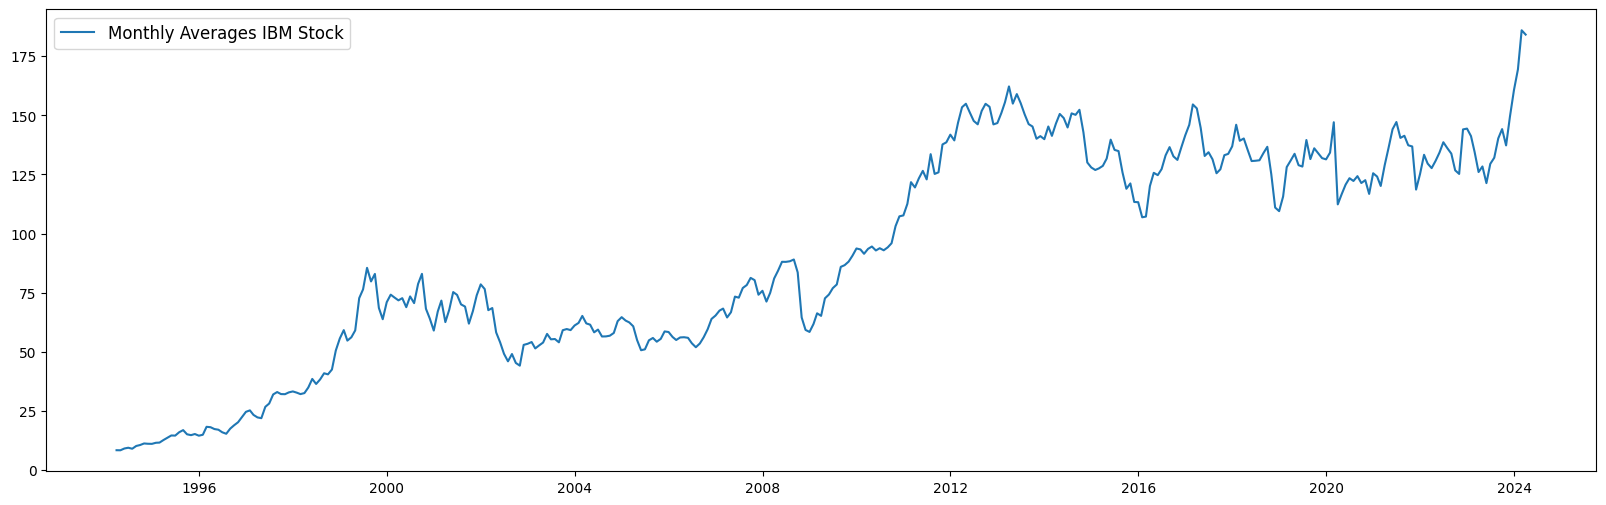

In [ ]:
IBM['Date'] = pd.to_datetime(IBM.Date)
newIBM = IBM.set_index('Date')
# Resample the data to the monthly level
monthly_data = newIBM[['Close', 'Open', 'High', 'Low', 'Volume']].resample('M').mean()
##Monthly Stock Price
fig = plt.figure(figsize=(20,6))
plt.plot(monthly_data['Close'],label='Monthly Averages IBM Stock')
plt.legend(prop={'size': 12})
plt.show()

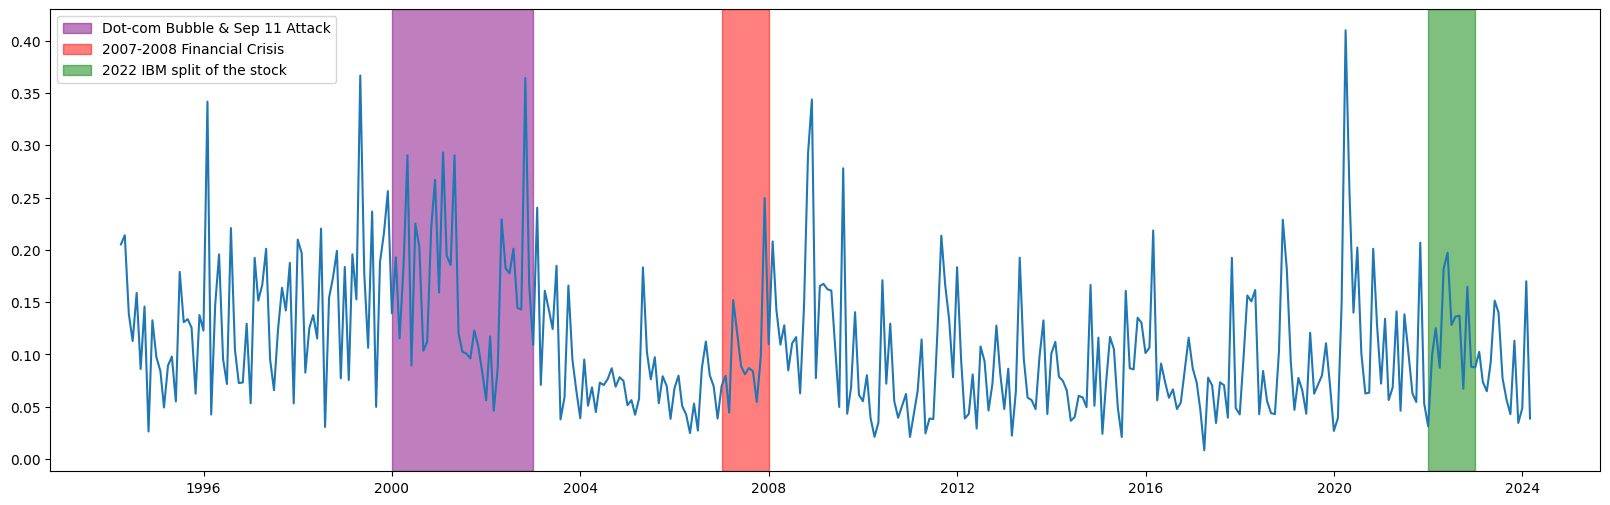

In [ ]:
# Calculate weekly returns using percentage change
weekly_returns = newIBM['Close'].pct_change()
weekly_returns.dropna(inplace=True)

# Resample to monthly data and calculate the standard deviation as a measure of volatility
# Then annualize the monthly volatility
monthly_volatility = weekly_returns.resample("M").std() * np.sqrt(12)

# Visualize major market events reflected in volatility
plt.figure(figsize=(20, 6))
plt.plot(monthly_volatility)
plt.axvspan('2000', '2003', color='purple', alpha=.5)
plt.axvspan('2007', '2008', color='red', alpha=.5)
plt.axvspan('2020', '2022', color='green', alpha=.5)
#plt.title("Monthly Annualized Volatility")

# Add legend for major market events
l1 = mpatches.Patch(color='purple', alpha=.5, label="Dot-com Bubble & Sep 11 Attack")
l2 = mpatches.Patch(color='red', alpha=.5, label="2007-2008 Financial Crisis")
l3 = mpatches.Patch(color='green', alpha=.5, label="2022 IBM split of the stock")
plt.legend(handles=[l1, l2, l3])

plt.show()

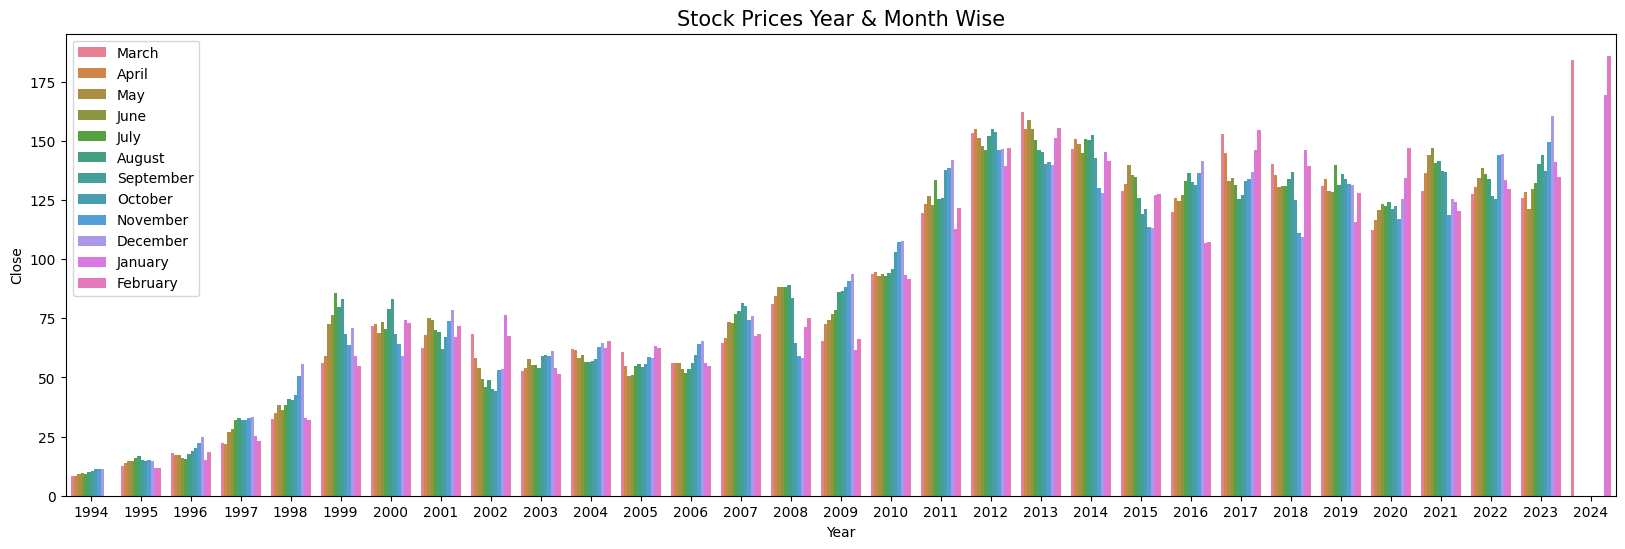

In [ ]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['Quarter'] = monthly_data.index.quarter
fig, ax = plt.subplots(figsize=(20,6))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="Close",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.show()

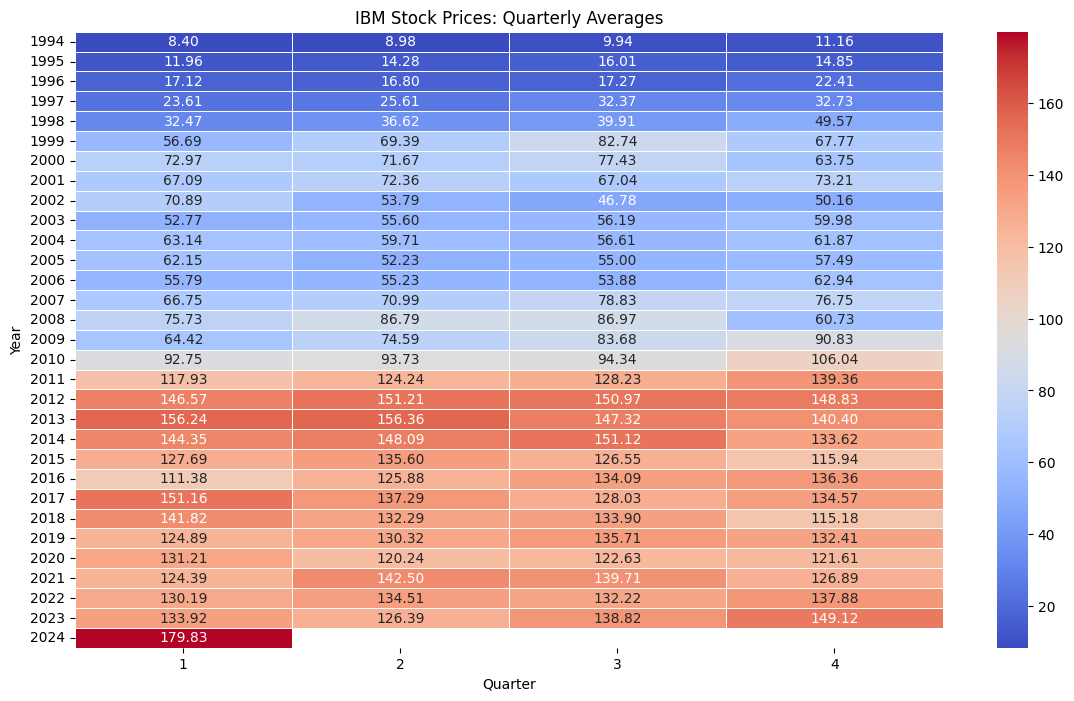

In [ ]:
quarter = monthly_data.groupby(["Year", "Quarter"])["Close"].mean().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(quarter, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
plt.title("IBM Stock Prices: Quarterly Averages")
plt.show()

### Data Preparation

#### Target Construction

In [ ]:
# Create Log(Return)
# Calculate logarithmic returns
IBM['Log_Return'] = np.log(IBM['Close'] / IBM['Close'].shift(1))
IBM['Log_Return'].fillna(0, inplace=True)  # Handle NaN values resulting from the shift

#### Covariates construction

In [ ]:
# Calculate Simple Moving Average (SMA)
IBM['SMA_50'] = ta.sma(IBM['Close'], length=50)  # 50-period SMA
IBM['SMA_200'] = ta.sma(IBM['Close'], length=200)  # 200-period SMA

# Calculate Exponential Moving Average (EMA)
IBM['EMA_12'] = ta.ema(IBM['Close'], length=12)  # 12-period EMA
IBM['EMA_26'] = ta.ema(IBM['Close'], length=26)  # 26-period EMA

# Calculate the Stochastic Oscillator components
stoch = ta.stoch(IBM['High'], IBM['Low'], IBM['Close'])
IBM = IBM.join(stoch)

# Calculate Relative Strength Index (RSI)
IBM['RSI_14'] = ta.rsi(IBM['Close'], length=14)  # 14-period RSI

# Calculate Moving Average Convergence Divergence (MACD)
macd = ta.macd(IBM['Close'])
IBM = IBM.join(macd)

In [ ]:
IBM['Date'] = pd.to_datetime(IBM['Date'])
IBM.set_index('Date', inplace=True)

In [ ]:
# Handle NaN:
IBM.dropna(inplace=True)

In [ ]:
IBM.shape

(1367, 16)

In [ ]:
dates = IBM.index

In [ ]:
# Calculate split indices
split_idx_train = int(len(IBM) * 0.7)
split_idx_val = int(len(IBM) * 0.9)

# Drop the specified columns and define the features and labels
X_IBM = IBM.drop(['Log_Return'], axis=1)
y_IBM = IBM['Log_Return']  # Log_Return as the target variable

# Ensure that indices are reset before splitting to avoid potential issues
X_IBM.reset_index(drop=True, inplace=True)
y_IBM.reset_index(drop=True, inplace=True)

# Split into training, validation, and testing sets
X_IBM_train = X_IBM.iloc[:split_idx_train, :]
X_IBM_val = X_IBM.iloc[split_idx_train:split_idx_val, :]
X_IBM_test = X_IBM.iloc[split_idx_val:, :]

y_IBM_train = y_IBM.iloc[:split_idx_train]
y_IBM_val = y_IBM.iloc[split_idx_train:split_idx_val]
y_IBM_test = y_IBM.iloc[split_idx_val:]

In [ ]:
IBM_dates_test = dates[split_idx_val:]

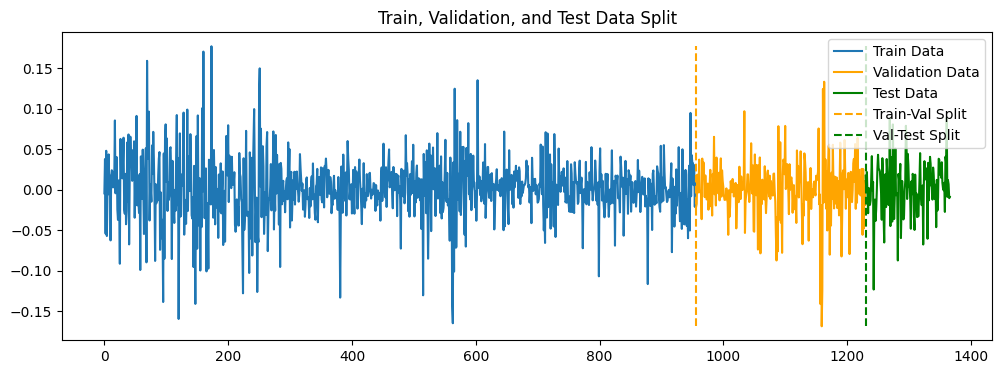

In [ ]:
# Indices for plotting
x_train = np.arange(len(y_IBM_train))
x_val = np.arange(len(y_IBM_train), len(y_IBM_train) + len(y_IBM_val))
x_test = np.arange(len(y_IBM_train) + len(y_IBM_val), len(y_IBM))

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(x_train, y_IBM_train, label="Train Data")
plt.plot(x_val, y_IBM_val, color='orange', label="Validation Data")
plt.plot(x_test, y_IBM_test, color='green', label="Test Data")
plt.vlines(len(y_IBM_train), ymin=min(y_IBM.min(), y_IBM.min(), y_IBM.min()), ymax=max(y_IBM.max(), y_IBM.max(), y_IBM.max()), label='Train-Val Split', linestyles='dashed', colors='orange')
plt.vlines(len(y_IBM_train) + len(y_IBM_val), ymin=min(y_IBM.min(), y_IBM.min(), y_IBM.min()), ymax=max(y_IBM.max(), y_IBM.max(), y_IBM.max()), label='Val-Test Split', linestyles='dashed', colors='green')
plt.legend()
plt.title("Train, Validation, and Test Data Split")
plt.show()

### Data Preprocessing

In [ ]:
from sklearn.preprocessing import power_transform

# Fit the transformer on the training data and transform it
X_IBM_train_transformed = power_transform(X_IBM_train.to_numpy(), method='yeo-johnson')

# Transform the validation data using the same transformer
X_IBM_val_transformed = power_transform(X_IBM_val.to_numpy(), method='yeo-johnson')

# Transform the test data using the same transformer
X_IBM_test_transformed = power_transform(X_IBM_test.to_numpy(), method='yeo-johnson')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_IBM_train_scaled = scaler.fit_transform(X_IBM_train_transformed)

# Transform the val data using the same scaler
X_IBM_val_scaled = scaler.transform(X_IBM_val_transformed)

# Transform the test data using the same scaler
X_IBM_test_scaled = scaler.transform(X_IBM_test_transformed)

In [ ]:
print(X_IBM_train_scaled.shape)
print(X_IBM_val_scaled.shape)
print(X_IBM_test_scaled.shape)

(956, 15)
(274, 15)
(137, 15)


### Models

#### Loss function: RMSE

##### RNNs

In [ ]:
!ls "/content/drive/MyDrive/ML_project/Colab"

 Amazon.ipynb   Cac.ipynb   Master.ipynb      Nasdaq.ipynb   __pycache__      Sp500.ipynb
 anns.py        IBM.ipynb   Microsoft.ipynb  'old files'    'RMSE all(RNN)'


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ML_project/Colab')
from anns import EnhancedSignAgreementLoss, rnns, create_sequences_rnns, SimpleRNN, RMSELoss

In [ ]:
# Ensure y_IBM_train and y_test are numpy arrays
y_IBM_train = y_IBM_train.to_numpy() if isinstance(y_IBM_train, pd.Series) else y_IBM_train
y_IBM_val = y_IBM_val.to_numpy() if isinstance(y_IBM_val, pd.Series) else y_IBM_val
y_IBM_test = y_IBM_test.to_numpy() if isinstance(y_IBM_test, pd.Series) else y_IBM_test

# Create sequences
time_steps = 10
X_IBM_train_seq, y_IBM_train_seq = create_sequences_rnns(X_IBM_train_scaled, y_IBM_train, time_steps)
X_IBM_val_seq, y_IBM_val_seq = create_sequences_rnns(X_IBM_val_scaled, y_IBM_val, time_steps)
X_IBM_test_seq, y_IBM_test_seq = create_sequences_rnns(X_IBM_test_scaled, y_IBM_test, time_steps)

X_IBM_train_tensor = torch.tensor(X_IBM_train_seq, dtype=torch.float32)
y_IBM_train_tensor = torch.tensor(y_IBM_train_seq, dtype=torch.float32)
X_IBM_val_tensor = torch.tensor(X_IBM_val_seq, dtype=torch.float32)
y_IBM_val_tensor = torch.tensor(y_IBM_val_seq, dtype=torch.float32)
X_IBM_test_tensor = torch.tensor(X_IBM_test_seq, dtype=torch.float32)
y_IBM_test_tensor = torch.tensor(y_IBM_test_seq, dtype=torch.float32)

# Prepare data loaders
IBM_train_dataset = TensorDataset(X_IBM_train_tensor, y_IBM_train_tensor)
IBM_train_loader = DataLoader(dataset=IBM_train_dataset, batch_size=32, shuffle=True)
IBM_val_dataset = TensorDataset(X_IBM_val_tensor, y_IBM_val_tensor)
IBM_val_loader = DataLoader(dataset=IBM_val_dataset, batch_size=32, shuffle=False)

# Prepare data for prediction
IBM_predict_dataset = TensorDataset(X_IBM_test_tensor, y_IBM_test_tensor)
IBM_predict_loader = DataLoader(IBM_predict_dataset, batch_size=32, shuffle=False)

In [ ]:
X_IBM_train_tensor.shape

torch.Size([946, 10, 15])

In [ ]:
# Set seed for NumPy
np.random.seed(20)

# Set seed for PyTorch
torch.manual_seed(20)

In [ ]:
# Initialize the RNN model
IBM_rnns_rmse = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(IBM_rnns_rmse.parameters(), lr=0.001)
loss_function = RMSELoss()
epochs = 100

best_model_state, best_val_loss = rnns(IBM_rnns_rmse, IBM_train_loader, IBM_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 0.05378664284944534, Val Loss: 0.0977385863661766
Epoch 11, Train Loss: 0.04895621910691261, Val Loss: 0.07192228734493256
Epoch 21, Train Loss: 0.037454139441251755, Val Loss: 0.06438148766756058
Epoch 31, Train Loss: 0.033522043377161026, Val Loss: 0.0645970031619072
Epoch 41, Train Loss: 0.03639094531536102, Val Loss: 0.0510922409594059
Epoch 51, Train Loss: 0.03579625487327576, Val Loss: 0.05767228826880455
Epoch 61, Train Loss: 0.04662150889635086, Val Loss: 0.056983642280101776
Epoch 71, Train Loss: 0.044642336666584015, Val Loss: 0.05537552759051323
Epoch 81, Train Loss: 0.03832858055830002, Val Loss: 0.05412556231021881
Epoch 91, Train Loss: 0.03024730645120144, Val Loss: 0.054257847368717194


In [ ]:
best_val_loss

tensor(0.0467)

In [ ]:
IBM_rnns_rmse.load_state_dict(best_model_state)
IBM_rnns_rmse.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
IBM_predictions = []
IBM_actuals = []

with torch.no_grad():
    for inputs, labels in IBM_predict_loader:
        outputs = IBM_rnns_rmse(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        IBM_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        IBM_actuals.extend(labels.cpu().numpy())

In [ ]:
IBM_rnns_rmse_predictions = np.array(IBM_predictions)
IBM_rnns_rmse_actuals = np.array(IBM_actuals)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming IBM_rnns_rmse_predictions and IBM_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
IBM_rnns_rmse_predicted_labels = (IBM_rnns_rmse_predictions >= 0).astype(int)
IBM_rnns_rmse_actual_labels = (IBM_rnns_rmse_actuals >= 0).astype(int)

# Calculate classifier metrics
IBM_rnns_rmse_accuracy = accuracy_score(IBM_rnns_rmse_actual_labels, IBM_rnns_rmse_predicted_labels)
IBM_rnns_rmse_precision = precision_score(IBM_rnns_rmse_actual_labels, IBM_rnns_rmse_predicted_labels)
IBM_rnns_rmse_recall = recall_score(IBM_rnns_rmse_actual_labels, IBM_rnns_rmse_predicted_labels)
IBM_rnns_rmse_f1 = f1_score(IBM_rnns_rmse_actual_labels, IBM_rnns_rmse_predicted_labels)

# Print the classification metrics
print("Accuracy:", IBM_rnns_rmse_accuracy)
print("Precision:", IBM_rnns_rmse_precision)
print("Recall:", IBM_rnns_rmse_recall)
print("F1 Score:", IBM_rnns_rmse_f1)

Accuracy: 0.48031496062992124
Precision: 0.5178571428571429
Recall: 0.4264705882352941
F1 Score: 0.467741935483871


###### Plots

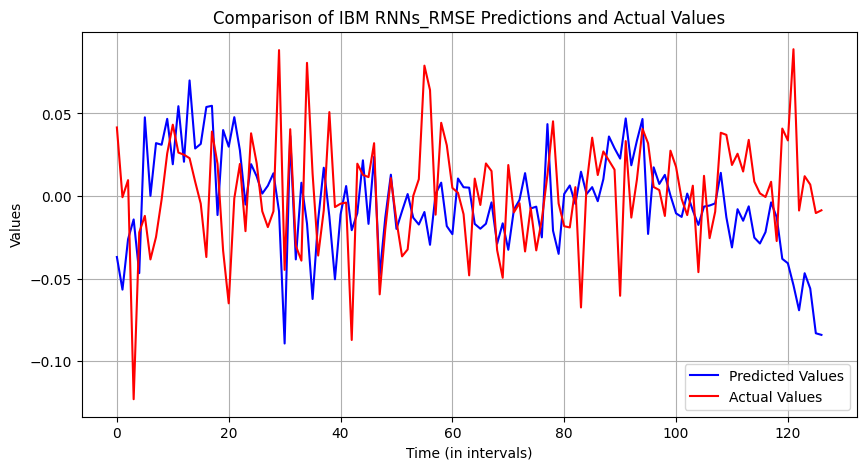

In [ ]:
# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(IBM_rnns_rmse_predictions, label='Predicted Values', color='blue')
plt.plot(IBM_rnns_rmse_actuals, label='Actual Values', color='red')
plt.title('Comparison of IBM RNNs_RMSE Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

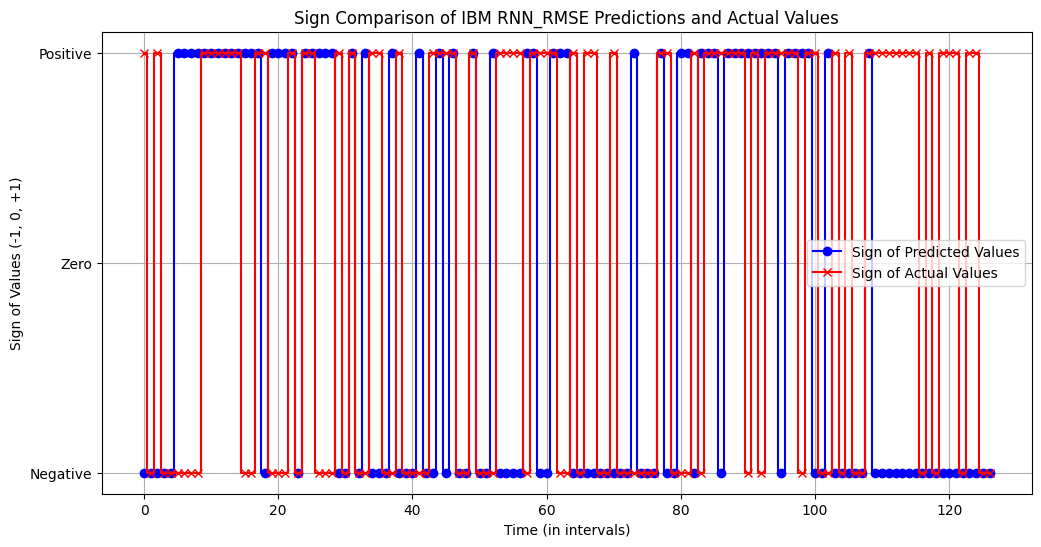

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions_rnn = np.sign(IBM_rnns_rmse_predictions)
signs_actuals_rnn = np.sign(IBM_rnns_rmse_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions_rnn)), signs_predictions_rnn, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals_rnn)), signs_actuals_rnn, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of IBM RNN_RMSE Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

##### ANFIS

In [ ]:
X_IBM_train_anfis = torch.tensor(X_IBM_train_scaled, dtype=torch.float32)
y_IBM_train_anfis = torch.tensor(y_IBM_train, dtype=torch.float32)
X_IBM_val_anfis = torch.tensor(X_IBM_val_scaled, dtype=torch.float32)
y_IBM_val_anfis = torch.tensor(y_IBM_val, dtype=torch.float32)
X_IBM_test_anfis = torch.tensor(X_IBM_test_scaled, dtype=torch.float32)
y_IBM_test_anfis = torch.tensor(y_IBM_test, dtype=torch.float32)

In [ ]:
X_IBM_train_anfis.shape

torch.Size([956, 15])

In [ ]:
from anns import ANFIS_RMSE
input_dim = X_IBM_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.005

# Initialize the ANFIS model
IBM_anfis_rmse = ANFIS_RMSE(functions=functions, input_dim=input_dim)

# Train the model
IBM_anfis_rmse.fit(X_IBM_train_anfis, y_IBM_train_anfis
                      , X_IBM_val_anfis, y_IBM_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
IBM_anfis_rmse_predictions = IBM_anfis_rmse.predict(X_IBM_test_anfis)

Epoch 1/100, Train Loss: 0.0405, Validation Loss: 0.0178
Epoch 11/100, Train Loss: 0.0013, Validation Loss: 0.0012
Epoch 21/100, Train Loss: 0.0012, Validation Loss: 0.0012
Epoch 31/100, Train Loss: 0.0012, Validation Loss: 0.0012
Epoch 41/100, Train Loss: 0.0012, Validation Loss: 0.0012
Epoch 51/100, Train Loss: 0.0011, Validation Loss: 0.0012
Epoch 61/100, Train Loss: 0.0011, Validation Loss: 0.0012
Epoch 71/100, Train Loss: 0.0010, Validation Loss: 0.0011
Epoch 81/100, Train Loss: 0.0010, Validation Loss: 0.0012
Epoch 91/100, Train Loss: 0.0009, Validation Loss: 0.0012
Best Validation Loss: 0.0011


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
IBM_anfis_rmse_predictions = IBM_anfis_rmse_predictions.detach().cpu().numpy()
IBM_anfis_rmse_actuals = y_IBM_test_anfis.detach().cpu().numpy()

# Function to convert values to 1 and 0 based on sign
# Positive sign (including zero for simplicity in binary classification) will be 1
# Negative sign will be 0
def sign_classify(values):
    return (np.sign(values) >= 0).astype(int)

# Classify both predictions and actuals
predicted_signs = sign_classify(IBM_anfis_rmse_predictions)
actual_signs = sign_classify(IBM_anfis_rmse_actuals)

# Calculate metrics directly comparing predicted and actual signs
IBM_anfis_rmse_accuracy = accuracy_score(actual_signs, predicted_signs)
IBM_anfis_rmse_precision = precision_score(actual_signs, predicted_signs)
IBM_anfis_rmse_recall = recall_score(actual_signs, predicted_signs)
IBM_anfis_rmse_f1 = f1_score(actual_signs, predicted_signs)

# Print the classification metrics
print("Accuracy:", IBM_anfis_rmse_accuracy)
print("Precision:", IBM_anfis_rmse_precision)
print("Recall:", IBM_anfis_rmse_recall)
print("F1 Score:", IBM_anfis_rmse_f1)

Accuracy: 0.8029197080291971
Precision: 0.8194444444444444
Recall: 0.8082191780821918
F1 Score: 0.8137931034482759


###### Plots

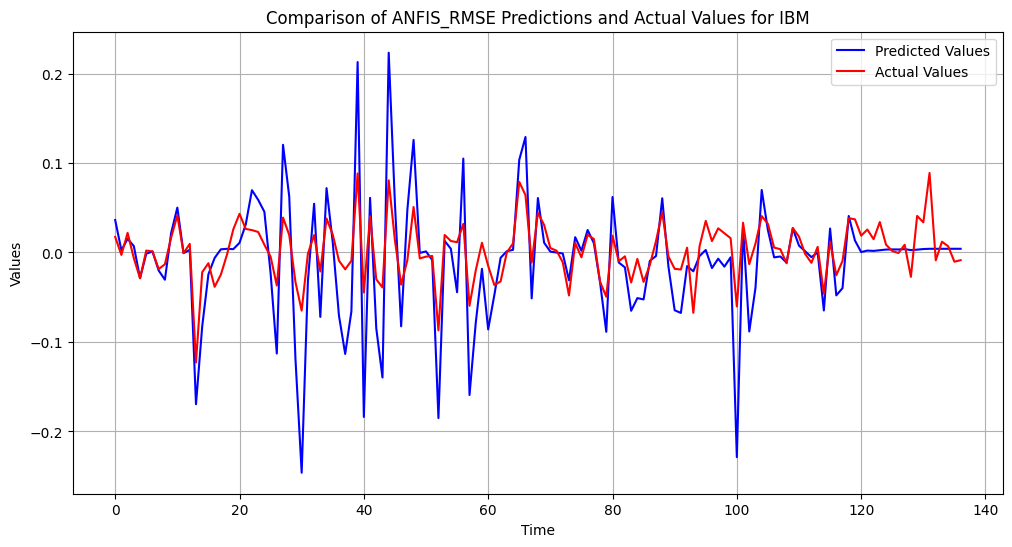

In [ ]:
# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(IBM_anfis_rmse_predictions, label='Predicted Values', color='blue')
plt.plot(IBM_anfis_rmse_actuals, label='Actual Values', color='red')
plt.title('Comparison of ANFIS_RMSE Predictions and Actual Values for IBM')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

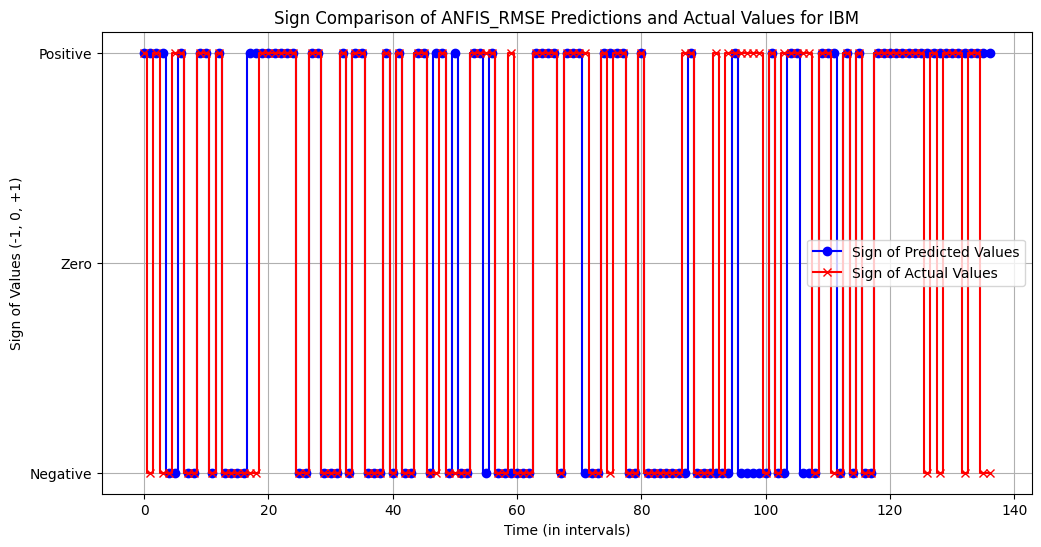

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions = np.sign(IBM_anfis_rmse_predictions)
signs_actuals = np.sign(IBM_anfis_rmse_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions)), signs_predictions, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals)), signs_actuals, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of ANFIS_RMSE Predictions and Actual Values for IBM')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

#### Custom loss function

##### RNNs

In [ ]:
from anns import EnhancedSignAgreementLoss
# Initialize the RNN model
IBM_rnns_custom = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(IBM_rnns_custom.parameters(), lr=0.001)
loss_function = EnhancedSignAgreementLoss(loss_penalty=5000)
epochs = 100

best_model_state, best_val_loss = rnns(IBM_rnns_custom, IBM_train_loader, IBM_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 3333.3447265625, Val Loss: 2534.726806640625
Epoch 11, Train Loss: 3888.890625, Val Loss: 2326.39111328125
Epoch 21, Train Loss: 3611.112060546875, Val Loss: 2309.029296875
Epoch 31, Train Loss: 2777.77880859375, Val Loss: 2343.75146484375
Epoch 41, Train Loss: 1944.4453125, Val Loss: 2447.91796875
Epoch 51, Train Loss: 1666.668212890625, Val Loss: 2482.640380859375
Epoch 61, Train Loss: 2777.77880859375, Val Loss: 2482.64013671875
Epoch 71, Train Loss: 1666.6678466796875, Val Loss: 2430.556640625
Epoch 81, Train Loss: 2777.778564453125, Val Loss: 2309.029296875
Epoch 91, Train Loss: 1111.1123046875, Val Loss: 2274.30712890625


In [ ]:
best_val_loss

tensor(2100.6960)

In [ ]:
IBM_rnns_custom.load_state_dict(best_model_state)
IBM_rnns_custom.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
IBM_predictions = []
IBM_actuals = []

with torch.no_grad():
    for inputs, labels in IBM_predict_loader:
        outputs = IBM_rnns_custom(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        IBM_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        IBM_actuals.extend(labels.cpu().numpy())

In [ ]:
IBM_rnns_custom_predictions = np.array(IBM_predictions)
IBM_rnns_custom_actuals = np.array(IBM_actuals)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming IBM_rnns_rmse_predictions and IBM_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
IBM_rnns_custom_predicted_labels = (IBM_rnns_custom_predictions >= 0).astype(int)
IBM_rnns_custom_actual_labels = (IBM_rnns_custom_actuals >= 0).astype(int)

# Calculate classifier metrics
IBM_rnns_custom_accuracy = accuracy_score(IBM_rnns_custom_actual_labels, IBM_rnns_custom_predicted_labels)
IBM_rnns_custom_precision = precision_score(IBM_rnns_custom_actual_labels, IBM_rnns_custom_predicted_labels)
IBM_rnns_custom_recall = recall_score(IBM_rnns_custom_actual_labels, IBM_rnns_custom_predicted_labels)
IBM_rnns_custom_f1 = f1_score(IBM_rnns_custom_actual_labels, IBM_rnns_custom_predicted_labels)

# Print the classification metrics
print("Accuracy:", IBM_rnns_custom_accuracy)
print("Precision:", IBM_rnns_custom_precision)
print("Recall:", IBM_rnns_custom_recall)
print("F1 Score:", IBM_rnns_custom_f1)

Accuracy: 0.4566929133858268
Precision: 0.49122807017543857
Recall: 0.4117647058823529
F1 Score: 0.448


###### Plots

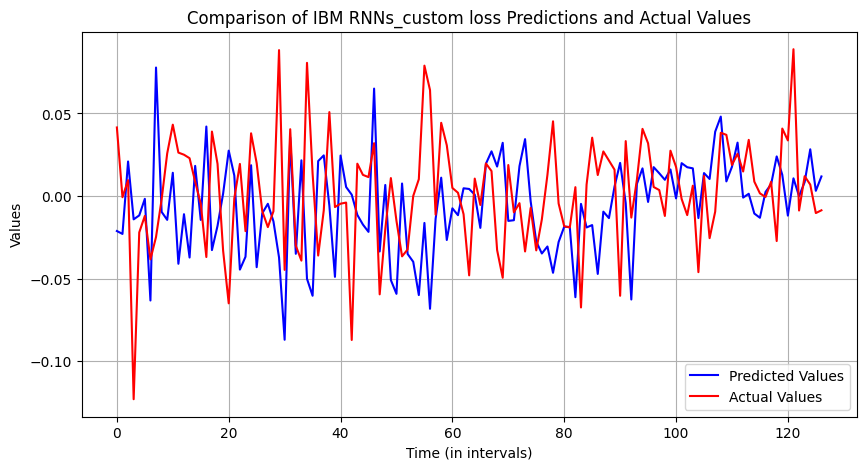

In [ ]:
# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(IBM_rnns_custom_predictions, label='Predicted Values', color='blue')
plt.plot(IBM_rnns_custom_actuals, label='Actual Values', color='red')
plt.title('Comparison of IBM RNNs_custom loss Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

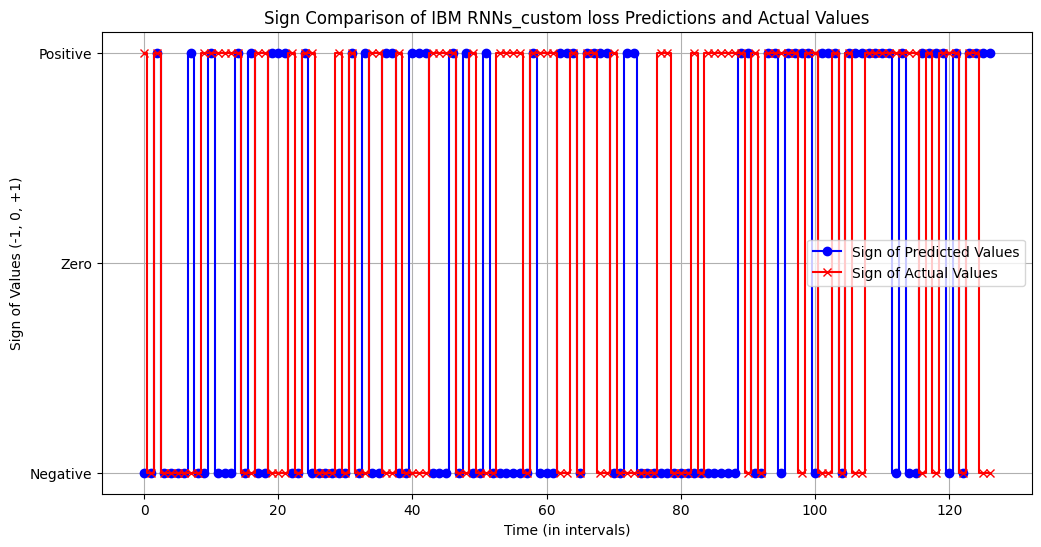

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions_rnn = np.sign(IBM_rnns_custom_predictions)
signs_actuals_rnn = np.sign(IBM_rnns_custom_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions_rnn)), signs_predictions_rnn, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals_rnn)), signs_actuals_rnn, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of IBM RNNs_custom loss Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

##### ANFIS

In [ ]:
from anns import ANFIS_CustomLoss

input_dim = X_IBM_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.01

# Initialize the ANFIS model
IBM_anfis_custom = ANFIS_CustomLoss(functions=functions, input_dim=input_dim, loss_penalty=5000)

# Train the model
IBM_anfis_custom.fit(X_IBM_train_anfis, y_IBM_train_anfis
                      , X_IBM_val_anfis, y_IBM_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
IBM_anfis_custom_predictions = IBM_anfis_custom.predict(X_IBM_test_anfis)

Epoch 1/100, Train Loss: 2489.5416, Val Loss: 2262.7750
Epoch 11/100, Train Loss: 2044.9802, Val Loss: 1952.5559
Epoch 21/100, Train Loss: 1976.9885, Val Loss: 1897.8114
Epoch 31/100, Train Loss: 1898.5365, Val Loss: 1697.0814
Epoch 41/100, Train Loss: 1752.0928, Val Loss: 1660.5851
Epoch 51/100, Train Loss: 1553.3480, Val Loss: 1532.8478
Epoch 61/100, Train Loss: 1548.1179, Val Loss: 1605.8408
Epoch 71/100, Train Loss: 1370.2935, Val Loss: 1605.8408
Epoch 81/100, Train Loss: 1584.7288, Val Loss: 1642.3374
Epoch 91/100, Train Loss: 1370.2935, Val Loss: 1587.5931
Best Validation Loss: 1478.1033


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
IBM_anfis_custom_predictions = IBM_anfis_custom_predictions.detach().cpu().numpy()
IBM_anfis_custom_actuals = y_IBM_test_anfis.detach().cpu().numpy()

# Function to convert values to 1 and 0 based on sign
def sign_classify(values):
    # Convert positive and zero values to 1, and negative values to 0
    return (np.sign(values) >= 0).astype(int)

# Classify both predictions and actuals
predicted_signs = sign_classify(IBM_anfis_custom_predictions)
actual_signs = sign_classify(IBM_anfis_custom_actuals)

# Calculate metrics directly using predicted and actual signs
IBM_anfis_custom_accuracy = accuracy_score(actual_signs, predicted_signs)
IBM_anfis_custom_precision = precision_score(actual_signs, predicted_signs)
IBM_anfis_custom_recall = recall_score(actual_signs, predicted_signs)
IBM_anfis_custom_f1 = f1_score(actual_signs, predicted_signs)

# Print the classification metrics
print("Accuracy:", IBM_anfis_custom_accuracy)
print("Precision:", IBM_anfis_custom_precision)
print("Recall:", IBM_anfis_custom_recall)
print("F1 Score:", IBM_anfis_custom_f1)

Accuracy: 0.8248175182481752
Precision: 0.7951807228915663
Recall: 0.9041095890410958
F1 Score: 0.846153846153846


###### Plots

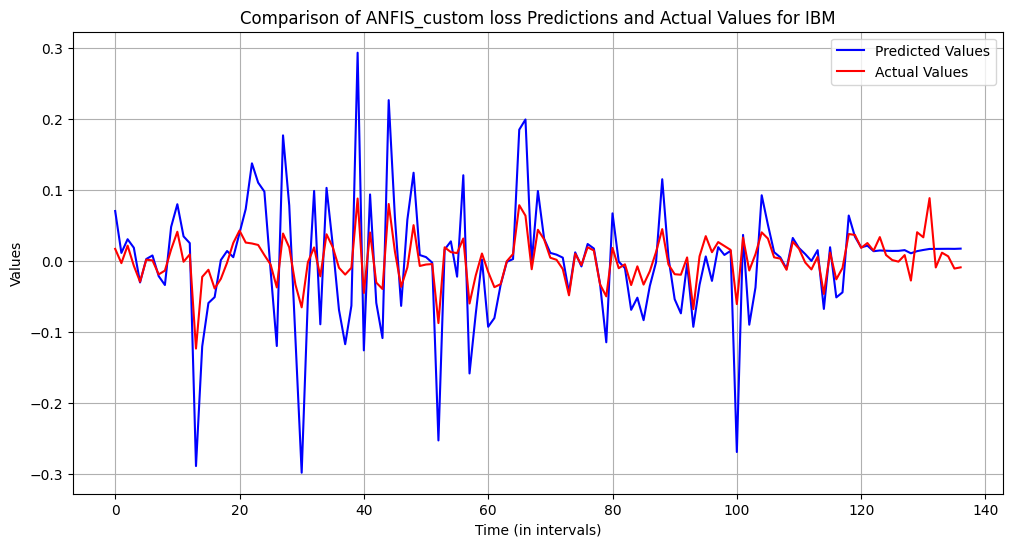

In [ ]:
# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(IBM_anfis_custom_predictions, label='Predicted Values', color='blue')
plt.plot(IBM_anfis_custom_actuals, label='Actual Values', color='red')
plt.title('Comparison of ANFIS_custom loss Predictions and Actual Values for IBM')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

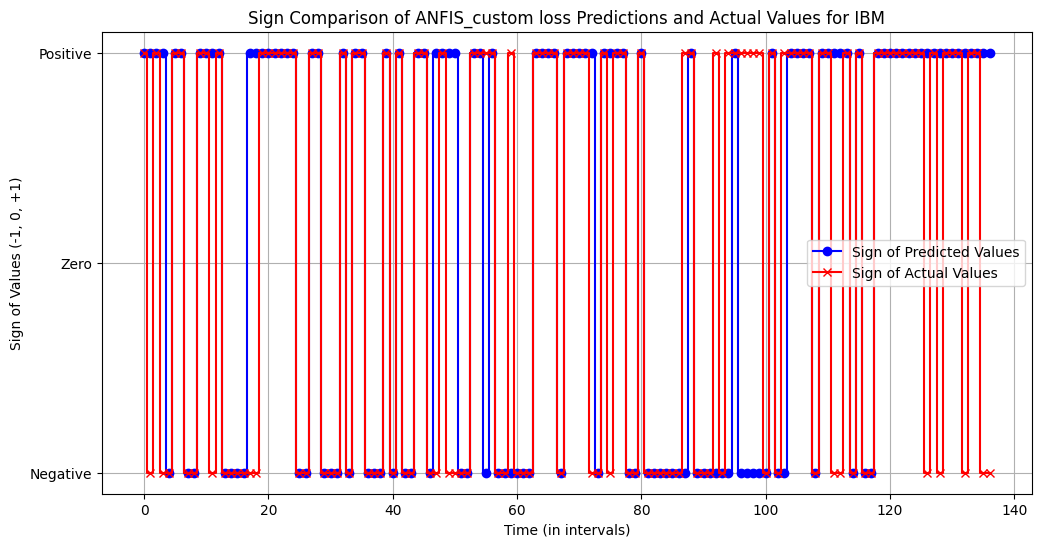

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions = np.sign(IBM_anfis_custom_predictions)
signs_actuals = np.sign(IBM_anfis_custom_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions)), signs_predictions, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals)), signs_actuals, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of ANFIS_custom loss Predictions and Actual Values for IBM')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()